In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import time
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn.modules import linear
from torchvision import models, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
from torch import optim 
from collections import defaultdict
import pickle 
from matplotlib import pyplot as plt 
import time

In [4]:
class Lenet(nn.Module):
    def __init__(self, n_classes=10, dropout=0.2):
        super(Lenet, self).__init__()

        self.n_classes = n_classes
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), #28*28*6
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, padding=0), #14*14*6
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), #10 * 10* 16
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, padding=0), # 5*5*16
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5), #1*1*120
            nn.Tanh(),
        )
        self.linear = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, n_classes),
            nn.Dropout(dropout)
        )
    
    def forward(self, images: Tensor):
        """
        input:
            images: batch_size * 3 *32 *32 
        
        outptu:
            tensor: batch_size * n_classes
        """
        outputs = self.convolution(images)
        outputs = outputs.reshape(outputs.size(0), -1)
        return self.linear(outputs)


class Alexnet(nn.Module):
    def __init__(self, n_classes:int = 10,
                 dropout:float = 0.2,
                 use_pretrained: bool = False
        ):
        super(Alexnet, self).__init__()
        self.n_classes = n_classes
        self.use_pretrained = use_pretrained
        if not self.use_pretrained:
            self.convolution = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
                nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
                nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
            )
            self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
            self.linear = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, n_classes),
            )
        else:
            alexnet = models.alexnet(pretrained=True)
            convolution_layers = list(alexnet.children())[:-1]
            linear_layers = list(alexnet.children())[-1][:-2]
            self.convolution = nn.Sequential(*convolution_layers)
            self.linear1 = nn.Sequential(*linear_layers)
            for param in self.convolution.parameters():
                param.requires_grad = False
            
            for param in self.linear1.parameters():
                param.requires_grad = False

            self.linear = nn.Linear(4096, 10)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, images):
        if not self.use_pretrained:
            outs = self.convolution(images)
            outs = self.avgpool(outs)
            outs = outs.reshape(outs.size(0), -1)
        else:
            outs = self.convolution(images)
            outs = outs.reshape(outs.size(0), -1)
            outs = self.linear1(outs)
        return self.linear(self.dropout(outs))
        

        

In [5]:
class Trainer:
    def __init__(self, model_name: str,
                batch_size: int = 64,
                lr: float = 1e-5,
                path_save_model: str = "",
                n_epochs: int = 100,
                use_pretrained: float = False,
                training_data_percent:float = 0.2
        ):
        self.model_name = model_name
        self.n_classes = 10
        self.batch_size = batch_size
        self.lr = lr 
        self.use_pretrained = use_pretrained
        self.training_data_percent = training_data_percent
        self.path_save_model = path_save_model
        self.n_epochs = n_epochs 
        self.loss_fn = nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.get_model()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        self.acc_test_current = 0
        self.make_loader()
    
    def get_model(self):
        if self.model_name == "lenet":
            model = Lenet(n_classes=self.n_classes).to(self.device)
            self.input_size = 32

        elif self.model_name =="alexnet":
            model = Alexnet(n_classes=self.n_classes, use_pretrained = self.use_pretrained).to(self.device)
            self.input_size = 224
        else:
            raise Exception("Not implement")

        return model
    
    def make_loader(self):
        self.transform = transforms.Compose([
            transforms.Resize(self.input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.train_set = torchvision.datasets.CIFAR10(root='./data', 
                                            train=True, 
                                            download=True,
                                            transform=self.transform
                                        )
        self.test_set = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=self.transform
                                        )
        self.n_train_samples = int(self.training_data_percent * len(self.train_set))
        self.n_val_samples = len(self.train_set) - self.n_train_samples
        self.train_set, self.val_set = random_split(
            self.train_set,
            lengths=[self.n_train_samples, self.n_val_samples],
            generator=torch.Generator().manual_seed(42),
        )
        self.train_loader = DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True,num_workers=2)
        self.val_loader = DataLoader(self.val_set, batch_size=self.batch_size, shuffle=True,num_workers=2)
        self.test_loader = DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=2)


    def train_on_epoch(self):
        self.model.train()
        train_loss = 0
        correct, total = 0, 0
        for idx,(images, labels) in enumerate(self.train_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)
            outs = self.model(images)
            self.optimizer.zero_grad()
            loss = self.loss_fn(outs, labels)
            loss.backward()
            self.optimizer.step()
            
            predict = torch.argmax(outs, dim=1)
            total += predict.size(0)
            correct += (predict == labels).sum().item()
            train_loss += loss.item()
            
#             if idx % 200 == 0:
#                 print(idx, end=" ")
        print()
        return train_loss/len(self.train_loader), correct / total
    
    def plot(self, title, file_name, train_values, val_values,is_acc=False):
        plt.plot(range(len(train_values)),train_values)
        plt.plot(range(len(train_values)),val_values)
        plt.title(title)
        if is_acc:
            plt.ylabel("Accuracy")
        else:
            plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(['Train', 'Val'])
        plt.show()
        plt.savefig(file_name)

    def plot_history(self):
        self.plot('Accuracy', 'acc.png', self.history['train_acc'], self.history['val_acc'], is_acc=True)
        self.plot('Loss', 'loss.png', self.history['train_loss'], self.history['val_loss'])

    def save_model(self, epoch):
        model_state ={
            "model" : self.model.state_dict(),
            "optimizer" : self.optimizer
        }
        torch.save(model_state, self.path_save_model+f'model{epoch}.pth')
        print("Save model done")
        with open(f"history{epoch}.pkl",'wb') as file:
            pickle.dump(self.history, file, protocol=pickle.HIGHEST_PROTOCOL)
        print("Save history done")
    
    def testing(self):
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outs = self.model(images)
                
                predict = torch.argmax(outs, dim=1)
                total += predict.size(0)
                correct += (predict == labels).sum().item()
        
        self.acc_test_current = 100 * correct / total
        print("Accuracy for testing: {:.2f}\n".format(self.acc_test_current))

    def evaluate(self):
        val_loss = 0
        self.model.eval()
        correct, total = 0, 0
        for idx,(images, labels) in enumerate(self.val_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)
            outs = self.model(images)
            loss = self.loss_fn(outs, labels)
            val_loss += loss.item()
            
            predict = torch.argmax(outs, dim=1)
            total += predict.size(0)
            correct += (predict == labels).sum().item()
#             if idx % 200 == 0:
#                 print(idx, end=" ")
        print()
        return val_loss/len(self.val_loader), correct / total
    

    def fit(self):
        self.history = defaultdict(list)
        best_acc = 0
        for epoch in range(self.n_epochs):
            start_time = time.time()
            train_loss, train_acc = self.train_on_epoch()
            val_loss, val_acc = self.evaluate()
            self.history['train_acc'].append(train_acc)
            self.history['train_loss'].append(train_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_loss'].append(val_loss)
            print(f"Epoch:{epoch}---Train acc:{train_acc}---Train loss:{train_loss}---Val acc:{val_acc}---Val loss:{val_loss}--Time:{time.time()-start_time}")            
            self.testing()
            if self.acc_test_current > best_acc and epoch >= 20:
                best_acc = self.acc_test_current 
                self.save_model(epoch)
                


In [6]:
trainer = Trainer(
    model_name='alexnet',
    lr=1e-4,
    n_epochs=100,
    batch_size=256,
    use_pretrained=True,
    training_data_percent=0.9
)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
print(len(trainer.train_loader))

176


In [8]:
print(len(trainer.val_loader))

20


In [9]:
trainer.fit()



Epoch:0---Train acc:0.3067111111111111---Train loss:2.3516623459079047---Val acc:0.624---Val loss:1.0734479427337646--Time:79.97430324554443
Accuracy for testing: 62.90



Epoch:1---Train acc:0.5087777777777778---Train loss:1.4845948977903887---Val acc:0.6946---Val loss:0.881868377327919--Time:74.7815363407135
Accuracy for testing: 69.28



Epoch:2---Train acc:0.5675111111111111---Train loss:1.29218831861561---Val acc:0.714---Val loss:0.8167827785015106--Time:75.82501411437988
Accuracy for testing: 71.47



Epoch:3---Train acc:0.5961333333333333---Train loss:1.2109650305726312---Val acc:0.725---Val loss:0.7787629246711731--Time:74.52933740615845
Accuracy for testing: 72.79



Epoch:4---Train acc:0.6158888888888889---Train loss:1.1566559665582397---Val acc:0.7334---Val loss:0.7461961269378662--Time:75.28041577339172
Accuracy for testing: 73.84



Epoch:5---Train acc:0.6311111111111111---Train loss:1.1184197305278345---Val acc:0.742---Val loss:0.7312426626682281--Time:73.50351905822754

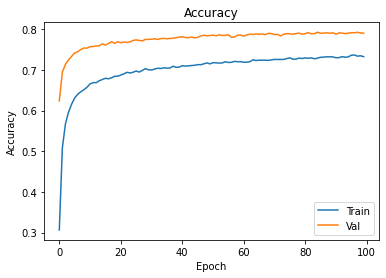

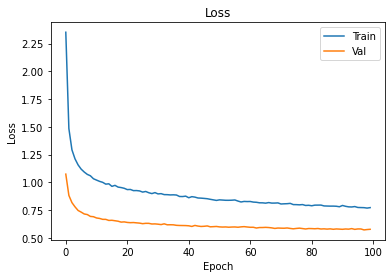

<Figure size 432x288 with 0 Axes>

In [10]:
trainer.plot_history()